Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('/Users/lzy/data/text8.zip', 31344016)

Found and verified /Users/lzy/data/text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

#words里面包含了所有的单词
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
#词汇表大小
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  
  #词-索引哈希
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  
  #用索引表示的整个text8文本
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  
  count[0][1] = unk_count
  # 索引-词哈希  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

生成skip-gram模型的训练batch

In [5]:
data_index = 0

# num_skips表示在两侧窗口内实际取多少个词，数量可以小于2*skip_window
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  
  #这里两个断言
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  #初始化batch和labels，都是整形
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) #注意labels的形状
  
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  #buffer这个队列太有用了，不断地保存span个单词在里面，然后不断往后滑动，而且buffer[skip_window]就是中心词
  buffer = collections.deque(maxlen=span)
  
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  #需要多少个中心词
  center_words_count=batch_size // num_skips
  for i in range(center_words_count):
    #skip_window在buffer里正好是中心词所在位置
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):  
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)  #当span=3时，target可以取0，1，2
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

# 打印前8个单词
print('data:', [reverse_dictionary[di] for di in data[:10]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'originated', 'a', 'originated', 'term', 'as', 'of']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
# 这里到底是怎么选择的？
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
#随机挑选一组单词作为验证集，valid_examples也就是下面的valid_dataset，是一个一维的ndarray
valid_examples = np.array(random.sample(range(valid_window), valid_size))

#这个值取多少合适？负采样数值
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 训练集和标签，以及验证集（注意验证集是一个常量集合）
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 这里的变量很重要！！要训练的embeddings，以及w和b
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # 这里很重要，用train_dataset去embeddings中取数据，train_dataset是一个一维的ndarray
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # Compute the softmax loss, using a sample of the negative labels each time.
  # 计算损失，tf.reduce_mean和tf.nn.sampled_softmax_loss
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.优化器，这里也会优化embeddings
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # 模型其实到这里就结束了，下面是在验证集上做效果验证
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:先对embeddings做正则化
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  #验证集单词与其他所有单词的相似度计算
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  #一直到训练结束，再对所有embeddings做一次正则化，得到最后的embedding
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.325583
Nearest to after: infective, vacuole, residuals, watershed, giant, qualified, julio, transonic,
Nearest to so: iroquois, vapor, destabilizing, nitroglycerin, ula, heights, trampled, mascarene,
Nearest to zero: flynt, refurbishment, cook, addictions, upc, arcadia, encountered, violation,
Nearest to was: sinbad, lulu, revealing, sorel, ladies, utraquists, commended, poincar,
Nearest to two: tr, kiesinger, legis, felony, fulgencio, apologized, distinguishes, jehovah,
Nearest to between: binary, transformations, yun, impression, pitches, giorgio, chemically, coinciding,
Nearest to new: strenuous, statistic, oversized, polyhedra, fullness, trojan, etta, mercantile,
Nearest to at: ogden, indication, examines, apparently, remixing, plywood, hornsby, lille,
Nearest to only: oaks, lebeau, polystyrene, multiply, dict, haemoglobin, perceptions, reenactment,
Nearest to used: eaton, autoerotic, interconnected, unidentified, excludes, datagrams, warehouse

In [16]:
num_points = 400
# 降维度PCA
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

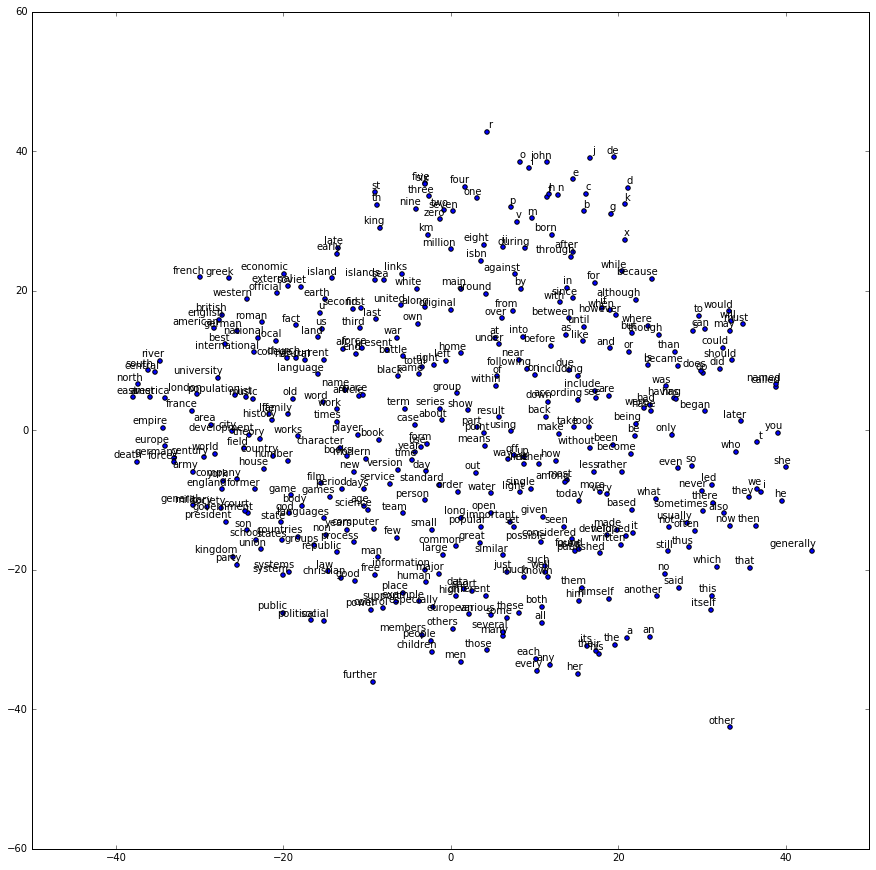

In [17]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [19]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size/num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i] = buffer[skip_window]
      labels[i*num_skips+j] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
    batch1=labels.reshape(batch_size/num_skips,num_skips)
    labels1=batch.reshape(batch_size/num_skips,1)
  return batch1,labels1

print('data:', [reverse_dictionary[di] for di in data[:8]])
print(data[:8])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch_size=8
    batch, labels = generate_batch(batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch.reshape(batch_size)])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size/num_skips)])
    print(batch,labels)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
[5239, 3084, 12, 6, 195, 2, 3137, 46]

with num_skips = 2 and skip_window = 1:
    batch: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term']
[[  12 5239]
 [   6 3084]
 [ 195   12]
 [   6    2]] [[3084]
 [  12]
 [   6]
 [ 195]]

with num_skips = 4 and skip_window = 2:
    batch: ['a', 'term', 'anarchism', 'originated', 'of', 'originated', 'term', 'as']
    labels: ['as', 'a']
[[   6  195 5239 3084]
 [   2 3084  195   12]] [[12]
 [ 6]]


In [20]:
batch_size = 256
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size/num_skips,num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size/num_skips, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.均匀分布
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],mean=0.0,
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = sum(tf.nn.embedding_lookup(embeddings, train_dataset[:,i]) for i in range(num_skips))
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  # 正则化的embeddings
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [21]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.526579
Nearest to nine: amputation, disintegration, nativist, visconti, confession, trochaic, hiatus, osce,
Nearest to five: panic, useless, announced, lds, technology, fro, tnt, proves,
Nearest to b: suez, malevich, atx, generis, bernoulli, jameson, icq, moray,
Nearest to years: itunes, parametric, devious, truck, noise, adequate, iona, didn,
Nearest to such: charmed, transmit, nimh, malaise, wes, athenaeus, railhead, mears,
Nearest to zero: evaporated, prostitution, faraday, hander, cont, sussex, modular, weights,
Nearest to while: endurance, wg, satanic, maguey, krieg, messe, derby, lempira,
Nearest to first: eunuch, cardboard, bidder, multiplying, expropriation, affinities, carefully, markov,
Nearest to world: intimidation, generality, hydrographic, derleth, then, whitehead, elongated, comedienne,
Nearest to over: ideogram, executables, boitano, date, key, kung, tongue, haldeman,
Nearest to may: behest, queue, specter, praia, labia, summon, sem

In [22]:
num_points = 400
# 降维度PCA
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

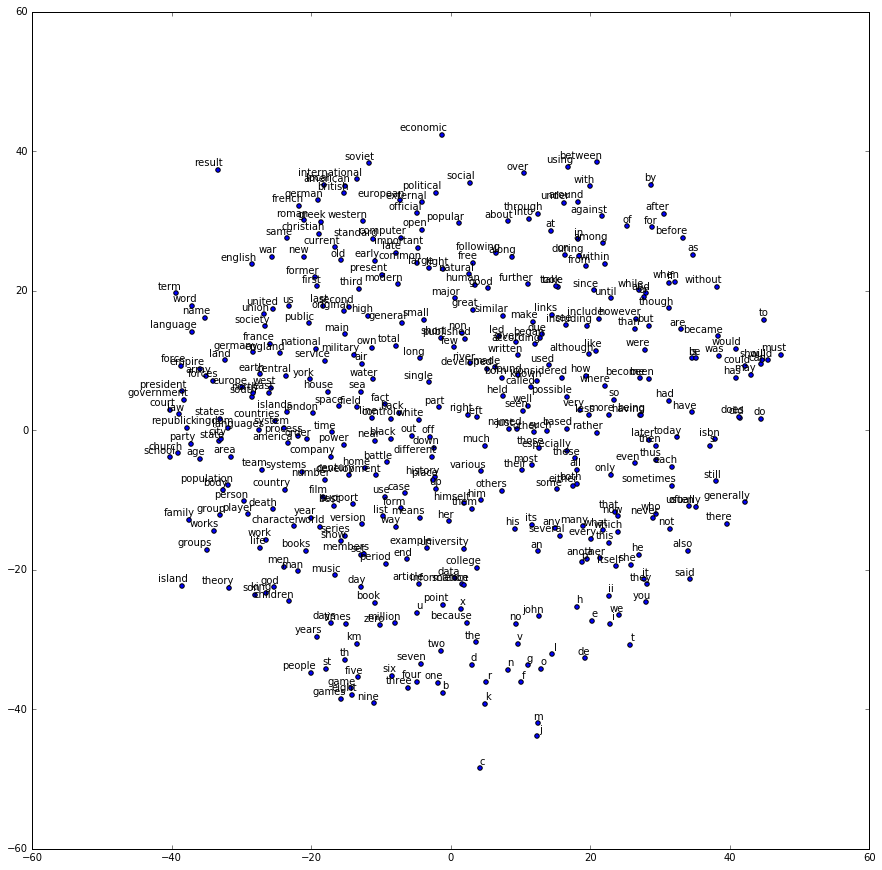

In [23]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)